#### Machine Learning IO
#  Machine Learning Training Classifier

<hr>

##### Make Money with Machine Learning
# Week 4 - Pneumonia Chest X-Ray Classifier

<ins>Course Task Description:</ins><br>

1. Build a $Image$ $Classifier$ o using $Tensorflow-Keras$ to predict Pneumonia Chest X-Rays using $Pneumonia Dataset$
2. Create at least two examples of making prediction using images.
3. Submitted as a $Jupyter Notebook$ via Github.

<ins>Background</ins><br>
There are four basic forms of Pneumonia:
  - 1) Bacterial 
  - 2) Viral 
  - 3) Mycoplasma
  - 4) Fungal
The Kaggle dataset only contains $Bacterial$ and $Viral$, and here are categorised together as one class.   

<ins>Credits and References:</ins>
 *   [Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning](https://github.com/anjanatiha/Pneumonia-Detection-from-Chest-X-Ray-Images-with-Deep-Learning) _Credit: Anjana Tiha_<br>
 
 *   [Deep Learning for Detecting Pneumonia from X-ray Images](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8) _Credit: Abhinav Sagar_<br>
 
 *   [Deep Learning Approach to Pneumonia Classification](https://www.hindawi.com/journals/jhe/2019/4180949/) _Credits: Okeke Stephen, Mangal Sain, Uchenna Joseph Maduh & Do-Un Jeong_<br> 
 
 *   [CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning](https://stanfordmlgroup.github.io/projects/chexnet/) _Credits: Pranav Rajpurkar, Jeremy Irvin, Kaylie Zhu, Brandon Yang, Hershel Mehta, Tony Duan, Daisy Ding, Aarti Bagul, Curtis Langlotz, Katie Shpanskaya, Matthew P. Lungren & Andrew Y. Ng_<br>
  
 *   [CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning](https://arxiv.org/abs/1711.05225)_Credits: Pranav Rajpurkar, Jeremy Irvin, Kaylie Zhu, Brandon Yang, Hershel Mehta, Tony Duan, Daisy Ding, Aarti Bagul, Curtis Langlotz, Katie Shpanskaya, Matthew P. Lungren, Andrew Y. Ng_<br>
  
  
<ins>Datasets</ins><br>
   *   [Kaggle: Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
   *   [Mendeley: Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification](https://data.mendeley.com/datasets/rscbjbr9sj/2)
   

<hr>

### Transfer Modeling Approach
The plan is to use two transfer learning techniques back-to-back:
- 1) Freeze the Bottom Layers: to only train the untrained randomly initialised Top Custom layers and usethe weights from the trained Base Model ($Inception$ $V3$).

- 2) Fine-Tune the Bottom Layers: after training the custom top layers, is to fine-tune the whole model, _i.e. train the whole model including the bottom layers using the weighted values_.

Expected outcomes:
After see a significant improvement in acccuracy and loss between the Freeze and Fine-Tune transfer learning steps, with no overfitting. 

Benefits of using the two Transfer Technique back-to-back:
- the bottom layers is better generalized for X-Ray images, _rather than normal images_.
- faster training times, _from the reduction in the batch size and number of epochs_.
- for reduced cost for high-end machines, _faster training on huge datasets and/or large models.
- the newly trained model can replace the Inception V3 model forother X-ray based Machine Learning Models.

_NOTES:_<br>
[1] _For automated production environments, it is actually possible to reduced and combine the two transfer learning steps 1) and 2) into a single step. Here the two steps have been intentionally kept separate to aid learning and experimentation._

[2] _There is higher risk of overfitting in the Fine-Tuning step, especially when running large number of epochs. The intuition is to see immediate improvements in accuracy and loss after a few epochs._

[3] _Changes to original code and commenting:_
  * _To aid understanding and experimentation_ 
  * _To overcome TensorFlow 2.0 and Keras issues_
  * _To improve Python programming and Machine Learning proficiency_
  * _To enable possible future code re-use and customization_
  * Code snippets from Tensorflow and Keras documentation, Github, Stackoverflow, Machine Learning

<hr>

# <center>IMPORT LIBRARIES</center>

<ins>computing environment</ins>

In [1]:
import sys
import os
import argparse
import io

<ins>standard</ins>

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

<ins>specials</ins>

In [3]:
import shutil

<ins>plotting and images</ins>

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
from IPython.core.pylabtools import figsize
from IPython.display import display
%matplotlib inline

import re
from PIL import Image
import cv2

<ins>machine learning</ins>

KERAS libraries

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.keras.backend.clear_session()  

In [6]:
import tensorflow.keras as keras
import keras.layers as Layers

Using TensorFlow backend.


In [7]:
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.constraints import MaxNorm as maxnorm

from tensorflow.keras import backend as k

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

OTHER libraries

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix

<ins>customisation</ins>

In [9]:
%%html
<style>
    table {float:left}
</style>

<hr>

## <center>HELPER FUNCTIONS</center>

### Directory and File formatting helper functions

REMOVE an existing directory

In [10]:
# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

CREATE or REMOVE a directory

In [11]:
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

CLEAR an exisitng directory 

In [12]:
def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True

REMOVE empty folder including subfolders

In [13]:
def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)

COUNT the number of files in a directory

In [14]:
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

PRINT date and time in different formats

In [15]:
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    elif x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    elif x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    elif x==4:  
        return 'Date today: %s' % datetime.date.today()

PRINT integer value center in a line _(debugging aid)_

In [16]:
def debug(x):
    print("-"*40, x, "-"*40)

REMOVE (STRIP) most non-alphabetical characters from a name string

In [17]:
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

COUNT number of files in each subdirectory of a directory

In [18]:
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)
    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts

<hr>

### Data Visualization helper functions

GET subplot params

In [19]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols
    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    return subplot_params

GET plot params

In [20]:
def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    plot_params["figsize"] = figsize
    plot_params["title"] = title
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    plot_params["legends"] = legends 
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    plot_params["subplot"] = None
    return plot_params

GET subplot figure and axis

In [21]:
def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs

GET file paths for image categories

In [22]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)
        subdir_file_count = len(subdir_files)
        subdir_file_mem = {}
        subdir_file_index = -1
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name
            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths

PLOT sample images

In [23]:
def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])

    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()

SHOW and PRINT sample image classification details

In [24]:
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*40, "All Class Printed:", class_count, "-"*40))

CREATE bar-plot

In [25]:
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)

SHOW bar-plot for count of labels in subdirectory of a directory

In [26]:
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    y = dir_file_count
    bar_plot(x, y, plot_property)

SHOW bar-plot for count of labels in training, validation, testing sub-directories   

In [27]:
  def show_train_val_test(train_directory, validation_directory, test_directory, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    title = plot_property['title']
      
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 
    count_bar_plot(train_directory, plot_property)
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no +1
    count_bar_plot(validation_directory, plot_property)
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(test_directory, plot_property)
    
    plt.show()

<hr>

### Tensorflow helper functions

RESET tensorflow graph tp free up memory and resource allocation 

In [28]:
def reset_callbacks():
    print("Reseting Callbacks at ", date_time(1))
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    return checkpoint, reduce_lr, early_stopping, tensorboard

<hr>

### CONFIGURE directory paths

In [29]:
callbacks = reset_callbacks()

Reseting Callbacks at  Timestamp: 2019-10-07 19:18:26


SETUP input directories

In [30]:
input_directory = r'data/input/'
train_directory      = input_directory + r'train'
validation_directory = input_directory + r'validation'
test_directory       = input_directory + r'test'

SETUP output directories

In [31]:
output_directory = r'data/output/'
figure_directory = output_directory + r'figures'

if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)

In [32]:
file_name_pred_batch = figure_directory+r'/result'
file_name_pred_sample = figure_directory+r'/sample'

In [33]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"

clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)

model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"

Removing empty folder: data/output/models/2019-10-07 19-17-24


<hr>

### <center>IMAGE VISUALISATION</center>
SHOW sample images by class

Number of Class:  2
-------------------------------------------------------Pneumonia-------------------------------------------------------


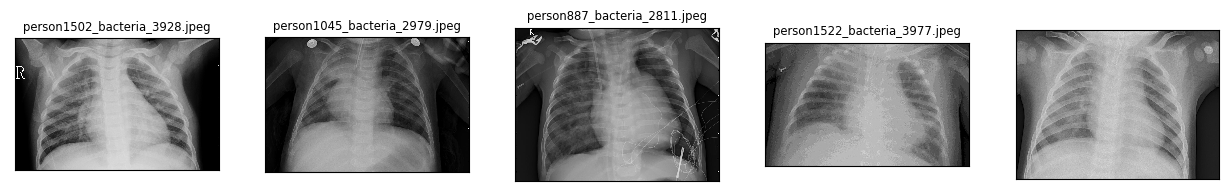


-------------------------------------------------------Normal-------------------------------------------------------


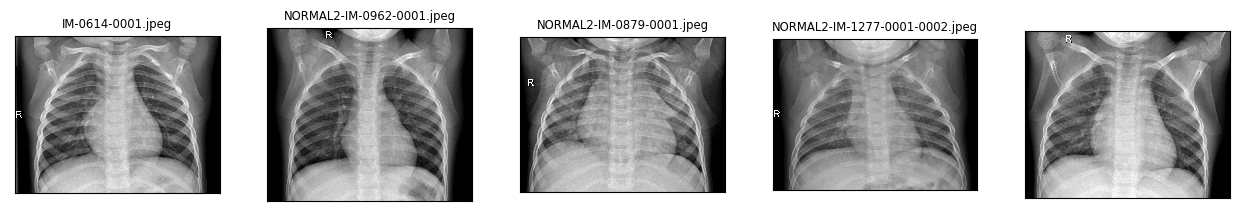


----------------------------------------All Class Printed:2----------------------------------------


In [34]:
show_class_sample_images(train_directory, image_count_per_category=5, 
                         save=False, dpi=100, update_image=False)

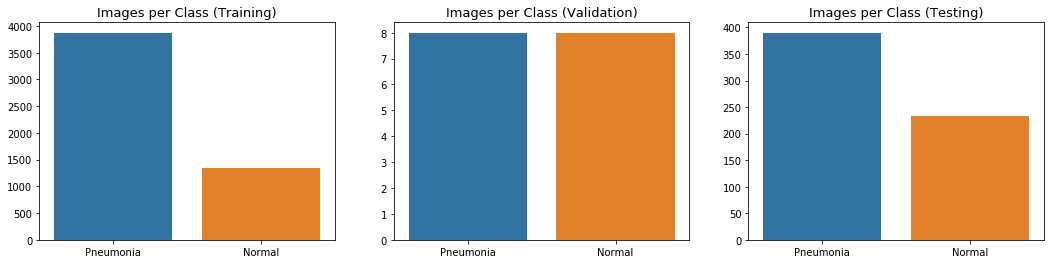

In [35]:
plot_params = get_reset_plot_params()
plot_params['figsize'] = (18,4)
plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10
plot_params['title'] = "Images per Class"
plot_params['subplot'] = 131

show_train_val_test(train_directory, validation_directory, test_directory, plot_params)
classes = os.listdir(train_directory)
classes = [name_correct(i) for i in classes]

<hr>

## <center>Image Preprocessing</center>

In [36]:
rescale = 1./255
target_size = (299, 299)
batch_size = 163
class_mode = "categorical"

train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_directory),
    shuffle = False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(test_directory),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


<hr>

### GET class weighting

HELPER function for class weight

In [37]:
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    cls_ix = pd.DataFrame(class_weight_current).reset_index()['index'].to_list()
    class_weight_dict = dict(zip(cls_ix, class_weight_current))
    return class_weight_dict, len(cls_ix)

In [38]:
class_weight, no_of_classes = get_weight(train_generator.classes)
[class_weight, no_of_classes]

[{0: 1.9448173005219984, 1: 0.6730322580645162}, 2]

<hr>

### Setup Callbacks

RESET callbacks 

In [39]:
callbacks = reset_callbacks()

Reseting Callbacks at  Timestamp: 2019-10-07 19:18:29


In [40]:
def set_callbacks(model_file, log_dir):
    checkpoint = ModelCheckpoint(
        model_file, 
        monitor='val_loss', 
        save_best_only=True)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=8,
        verbose=1,
        restore_best_weights=True)

    tensorboard = TensorBoard(
        log_dir=log_dir,
        update_freq = 'batch')

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        patience=5,
        cooldown=2,
        min_lr=0.000000001,
        verbose=1)
    print("Set Callbacks at ", date_time(1))
    return [checkpoint, reduce_lr, early_stopping, tensorboard]

In [41]:
callbacks = set_callbacks(model_file, log_dir)

Set Callbacks at  Timestamp: 2019-10-07 19:18:29


CREATE model parameters

In [42]:
model_params = train_generator, validation_generator, callbacks, class_weight

<hr>

### HELP FUNCTIONS - model creation and training

CREATE Inception V3 base model

In [43]:
def inception_v3_base_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))    
    for layer in base_model.layers:
        layer.trainable = False
    return base_model   

DEFINE basic architecture of Top Layers

In [44]:
def define_model(top_layer_sizes):
    model = Sequential()  
    model.add(inception_v3_base_model())
    model.add(Flatten(input_shape=model.output_shape[1:]))
    model.add(Dropout(0.5))
    model.add(Dense(top_layer_sizes[0], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(top_layer_sizes[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(top_layer_sizes[2], activation='softmax'))
    model.summary()
    return model

TRAIN model (sub-function)

In [45]:
def train_model(model, model_params, epochs=100):
    train_generator, validation_generator, callbacks, class_weight = model_params
    history = model.fit_generator(
        model_params[0],
        steps_per_epoch = len(model_params[0]),
        epochs=epochs, 
        verbose=1,
        callbacks=model_params[2],
        class_weight=model_params[3],
        validation_data=model_params[1],
        validation_steps=len(model_params[1]))
    
    print("Completed Model Trainning", date_time(1))
    return model, history

CREATE and COMPILE model

In [46]:
def create_model(model="", mode=1, top_layer_sizes=[1024,1024,2]):

    # If no model has been specified create a new frozen model
    if model=="":
        mode = 1  
    
    print("Configuring Trainable Layers", date_time(1))
    trainable_modes(mode)
    model = trainable_layers(model, top_layer_sizes, mode=mode)

    print("Compiling Model", date_time(1))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'] )

    return model

CHECK and print layer training mode

In [47]:
def trainable_modes(mode):
    if mode == 0:
        print('Training Model Only', date_time(1))        
    elif mode == 1:
        print('Creating a new Frozen Model', date_time(1))        
    elif mode == 2:
        print('Creating Fully Trainable New Model', date_time(1))
    elif mode == 3:
        print('Creating Fine-Tune Model', date_time(1))   
    else:
        print('Invalid Mode Value: set "mode" value in the range 0 to 3')  

SETUP model and configure layers training

In [48]:
def trainable_layers(model, top_layer_sizes, mode=1):
    
    # CREATE a new model
    if mode < 3:
        model = define_model(top_layer_sizes) 
    
    # MAKE the whole model trainable
    if mode > 1:
        for layer in model.layers:
            layer.trainable = True
    return model

<hr>

### HELP FUNCTION  Model Accuracy and Loss Plotting

CREATE X and Y Accuracy and Loss parameters

In [49]:
def acc_loss_xy_params(history, label):
    ylim_pad = [0.01, 0.1]

    if label == 'Accuracy' or label == 'accuracy':
        short_label = 'accuracy'
        ix = 0
    else:
        short_label = 'loss'
        ix = 1
    
    y1 = history.history[short_label]
    y2 = history.history['val_'+short_label]

    min_y = min(min(y1), min(y2))-ylim_pad[ix]
    max_y = max(max(y1), max(y2))+ylim_pad[ix]
    return y1, y2, min_y, max_y

CREATE Accuracy and Loss subplots

In [50]:
def acc_loss_subplot(history, label):    
    y1, y2, min_y, max_y = acc_loss_xy_params(history, label)
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.plot(y1)
    plt.plot(y2)
    plt.title('Model '+label, fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(label, fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    return plt

CREATE Training Accuracy and Loss plots

In [51]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(13, 5))

    plt.subplot(121)
    acc_loss_subplot(history, 'Accuracy')

    plt.subplot(122)
    acc_loss_subplot(history, 'Loss')
    
    plt.show()

CREATE Test Accuracy and Loss Results

In [52]:
def training_results(model, test_generator):
    print("Training Results")
    result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
    print("%s%.2f  "% ("Loss     : ", result[0]))
    print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

CREATE Test Confusion Matrix and Classification Accuracy Results 

In [53]:
def prediction_results(model, test_generator, figure_directory, class_map):
    print("Prediction results")
    y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
    y_pred = y_pred.argmax(axis=-1)
    y_true=test_generator.classes
    
    class_list = list(class_map.values())
    
    image_file_name_CM = figure_directory+"/CM"
    title = model_file.split("/")
    model_title = "/".join([i for i in title[3:]])
    precision = precision_score(y_true, y_pred) 
    recall = recall_score(y_true, y_pred) 
    f1 = f1_score(y_true, y_pred) 

    print("-"*90)
    print("Validation Report")
    print("-"*90)
    print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))
    print("-"*90)
    print("\n\n")
    
    CM = confusion_matrix(y_true, y_pred.round())
    plot_confusion_matrix(CM, figsize=(10,8))
    plt.xticks(range(len(class_list)), class_list, fontsize=10)
    plt.yticks(range(len(class_list)), class_list, fontsize=10)
    plt.title("Confusion Matrix for Model File (Test Dataset): \n"+model_title, fontsize=11)
    plt.show()
    
    cls_report_print = classification_report(y_true, y_pred, target_names=classes)
    cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    print("\n\n")
    print("-"*90)
    print("Classification Report for Model File: ", model_title)
    print("-"*90)
    print(cls_report_print)
    print("-"*90)
    return y_true, y_pred

CREATE test batch summary

In [54]:
def batch_summary(model, test_generator, y_true, y_pred):    
    numofbatch = len(test_generator)
    batch_no = random.randint(0, numofbatch-1)

    y_img_batch, y_true_batch = test_generator[batch_no] 
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)

    sizeofbatch = len(y_true_batch)
    print("-"*35)
    print("%s%d"%     ("Selected Batch No       : ", batch_no))
    print("-"*35)
    print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
    print("-"*35)
    print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
    print("-"*35)
    return y_img_batch, y_true_batch,  y_pred_batch

CREATE show predictions

In [55]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, test_directory, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))
            m[num]=1

        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(test_directory+'/'+ file_names[num], 1)
        
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')
        """if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   """

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

LIST model folders in models directory (sub-function)

In [80]:
def list_model_subdir():
    dir_name = r"data/output/models/"
    dirs = os.listdir(dir_name)
    for i in range(len(dirs)):
        if dirs[i] != '.DS_Store':
            print(i, dirs[i])
    return dir_name, dirs

LIST models in current directory (sub-function)

In [81]:
def models_current_subdir(dir_name, dirs):  
    if dirs[0] != '.DS_Store':
        cur_dir =dir_name+dirs[0]+"/"
    else:
        cur_dir =dir_name+dirs[1]+"/"
        
    model_names = os.listdir(cur_dir)
    for i in range(len(model_names)):
        print(i, model_names[i]) 
    return cur_dir, model_names

LIST the current model (sub-function)

In [89]:
def get_current_model(cur_dir, model_names):
    # Expects filename format, e.g.: 01-val_acc-0.62-val_loss-1.56.hdf5
    try:
        i = get_best_model_idx(model_names)
    except:
        print('Model Filename Error!')
        print('Example filename format: 01-val_acc-0.62-val_loss-1.56.hdf5')
        return
    
    model_file = cur_dir+model_names[i]
    print(model_file)
    return model_file

SELECT the model with minimum loss (sub-function)

In [88]:
def get_best_model_idx(model_names):
    # Model filename example: 01-val_acc-0.62-val_loss-1.56.hdf5
    df = pd.DataFrame(model_names)[0].map(lambda x: x.rstrip('.hdf5')).str.split("-", n = 5, expand = True)
    return pd.to_numeric(df[4]).idxmin()

LOAD the model with the minimum loss (main-function)

In [84]:
def load_current_model():
    print('List Model Directories')
    dir_name, dirs = list_model_subdir()
    print("_"*75) 
     
    print('List Models in Current Directory')
    cur_dir, model_names = models_current_subdir(dir_name, dirs)
    print("_"*75) 
   
    print('Get Current Model')
    model_file = get_current_model(cur_dir, model_names)
    print("_"*75) 
    
    model = keras.models.load_model(model_file)
    return model

<hr>

## <center>Step 01: TRANSFER LEARNING - Frozen Model</center> 

CREATE Frozen model using Inception V3 base model

CREATE, COMPILE and TRAIN Frozen model

In [60]:
top_layer_sizes = [1024,1024, no_of_classes] 
model = create_model(top_layer_sizes=top_layer_sizes)
model, history = train_model(model, model_params)

Configuring Trainable Layers Timestamp: 2019-10-07 19:18:29
Creating a new Frozen Model Timestamp: 2019-10-07 19:18:29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
___

PLOT Accuracy and Loss

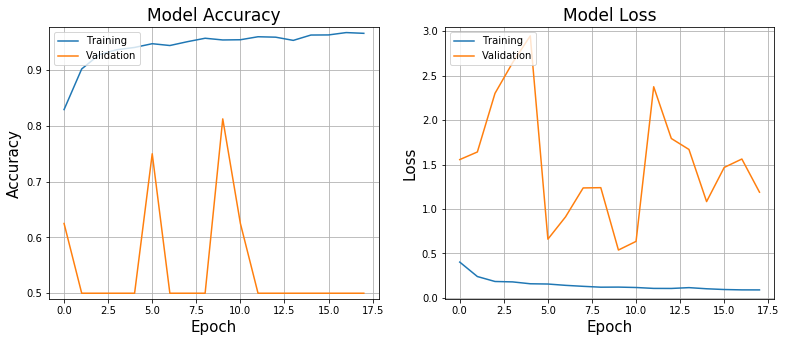

In [61]:
plot_accuracy_loss(history)

CHECK and LOAD current (best) Model

In [90]:
model = load_current_model()

List Model Directories
1 2019-10-07 19-18-26
___________________________________________________________________________
List Models in Current Directory
0 01-val_acc-0.62-val_loss-1.56.hdf5
1 06-val_acc-0.75-val_loss-0.66.hdf5
2 10-val_acc-0.81-val_loss-0.54.hdf5
___________________________________________________________________________
Get Current Model
data/output/models/2019-10-07 19-18-26/10-val_acc-0.81-val_loss-0.54.hdf5
___________________________________________________________________________


CREATE class map

In [91]:
class_map = {v: k for k, v in test_generator.class_indices.items()}

PRINT accuracy and loss

Prediction results
1/1 [==============================] - 102s 102s/step
------------------------------------------------------------------------------------------
Validation Report
------------------------------------------------------------------------------------------
Precision     : 86.92%
Recall        : 76.67%
F1-Score      : 81.47%
------------------------------------------------------------------------------------------





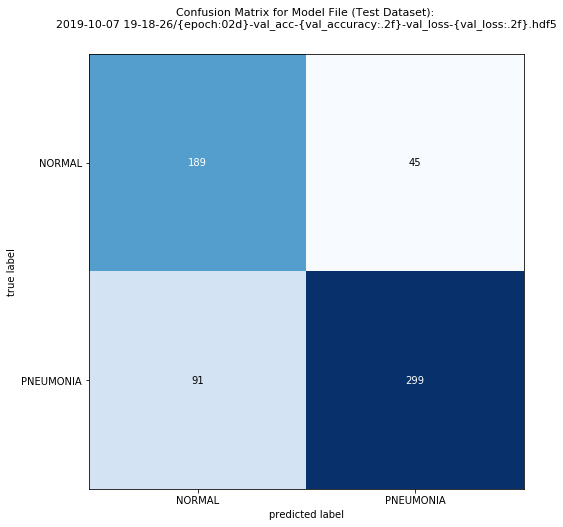




------------------------------------------------------------------------------------------
Classification Report for Model File:  2019-10-07 19-18-26/{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

   Pneumonia       0.68      0.81      0.74       234
      Normal       0.87      0.77      0.81       390

    accuracy                           0.78       624
   macro avg       0.77      0.79      0.78       624
weighted avg       0.80      0.78      0.78       624

------------------------------------------------------------------------------------------


In [92]:
y_true, y_pred = prediction_results(model, test_generator, figure_directory, class_map)

In [93]:
training_results(model, test_generator)

Training Results
1/1 [==============================] - 87s 87s/step - loss: 0.5614 - accuracy: 0.7821
Loss     : 0.56  
Accuracy : 78.21%


In [94]:
y_img_batch, y_true_batch,  y_pred_batch = batch_summary(model, test_generator, y_true, y_pred) 

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 78.21%
-----------------------------------


CREATE plot parameters

In [95]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"
batch_size_t = len(y_true_batch)
dpi=100
ncols = 8
nrows = 4
count = ncols*nrows

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

<hr>

## <center>Step 2: TRANSFER LEARNING - FINE-TUNE</center>

### Mini Training Cycle
Fully train saved frozen model _(for 5 epochs)_

EXPLORE and then LOAD saved Frozen model

In [96]:
model = load_current_model()

List Model Directories
1 2019-10-07 19-18-26
___________________________________________________________________________
List Models in Current Directory
0 01-val_acc-0.62-val_loss-1.56.hdf5
1 06-val_acc-0.75-val_loss-0.66.hdf5
2 10-val_acc-0.81-val_loss-0.54.hdf5
___________________________________________________________________________
Get Current Model
data/output/models/2019-10-07 19-18-26/10-val_acc-0.81-val_loss-0.54.hdf5
___________________________________________________________________________


CREATE and TRAIN Fine-Tune Model 
_Note: mode=3 => converts frozen model into fully trainable model_

In [97]:
model = create_model(model, mode=3)
model, history = train_model(model, model_params, epochs=5)

Configuring Trainable Layers Timestamp: 2019-10-08 11:16:32
Creating Fine-Tune Model Timestamp: 2019-10-08 11:16:32
Compiling Model Timestamp: 2019-10-08 11:16:32
Epoch 1/5
32/32 [==============================] - 1015s 32s/step - loss: 0.2113 - accuracy: 0.9421 - val_loss: 7.5578 - val_accuracy: 0.5000
Epoch 2/5
32/32 [==============================] - 1005s 31s/step - loss: 0.0785 - accuracy: 0.9732 - val_loss: 5.6235 - val_accuracy: 0.5000
Epoch 3/5
32/32 [==============================] - 1008s 31s/step - loss: 0.0575 - accuracy: 0.9762 - val_loss: 0.4194 - val_accuracy: 0.8750
Epoch 4/5
32/32 [==============================] - 1017s 32s/step - loss: 0.0543 - accuracy: 0.9816 - val_loss: 0.8952 - val_accuracy: 0.6250
Epoch 5/5
32/32 [==============================] - 1012s 32s/step - loss: 0.0408 - accuracy: 0.9864 - val_loss: 1.9330 - val_accuracy: 0.6875
Completed Model Trainning Timestamp: 2019-10-08 12:40:53


PLOT Accuracy and Loss

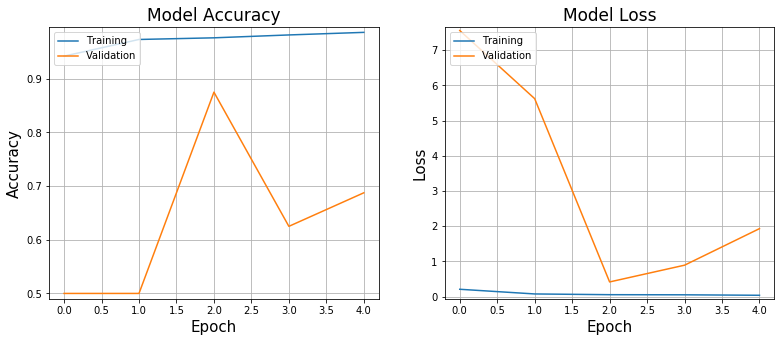

In [98]:
plot_accuracy_loss(history)

<hr>

### Main Training Cycle
The main fine-tune training of the fully trainable model _(for a max of 100 epochs)_

In [99]:
model = load_current_model()

List Model Directories
1 2019-10-07 19-18-26
___________________________________________________________________________
List Models in Current Directory
0 01-val_acc-0.62-val_loss-1.56.hdf5
1 06-val_acc-0.75-val_loss-0.66.hdf5
2 03-val_acc-0.88-val_loss-0.42.hdf5
3 10-val_acc-0.81-val_loss-0.54.hdf5
___________________________________________________________________________
Get Current Model
data/output/models/2019-10-07 19-18-26/03-val_acc-0.88-val_loss-0.42.hdf5
___________________________________________________________________________


CREATE and TRAIN Fine-Tune Model 
_Notes: 
 * _set to mode=3 (default) => To make bottom layers fully trainable, assumes previous model trained_
 * _set to mode=0 => Training only, more optimal if loaded model is already fully trainable model_

In [100]:
model = create_model(model, mode=3)
model, history = train_model(model, model_params)

Configuring Trainable Layers Timestamp: 2019-10-08 12:46:13
Creating Fine-Tune Model Timestamp: 2019-10-08 12:46:13
Compiling Model Timestamp: 2019-10-08 12:46:13
Epoch 1/100
32/32 [==============================] - 1088s 34s/step - loss: 0.1177 - accuracy: 0.9594 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 2/100
32/32 [==============================] - 1039s 32s/step - loss: 0.0918 - accuracy: 0.9659 - val_loss: 8.0590 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 1032s 32s/step - loss: 0.0668 - accuracy: 0.9780 - val_loss: 4.2442 - val_accuracy: 0.6250
Epoch 4/100
32/32 [==============================] - 1034s 32s/step - loss: 0.0511 - accuracy: 0.9787 - val_loss: 4.2384 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 1037s 32s/step - loss: 0.0561 - accuracy: 0.9827 - val_loss: 0.1094 - val_accuracy: 0.9375
Epoch 6/100
32/32 [==============================] - 1038s 32s/step - loss: 0.0405 - accuracy: 0.9843 - val_loss: 1.8

PLOT Accuracy and Loss

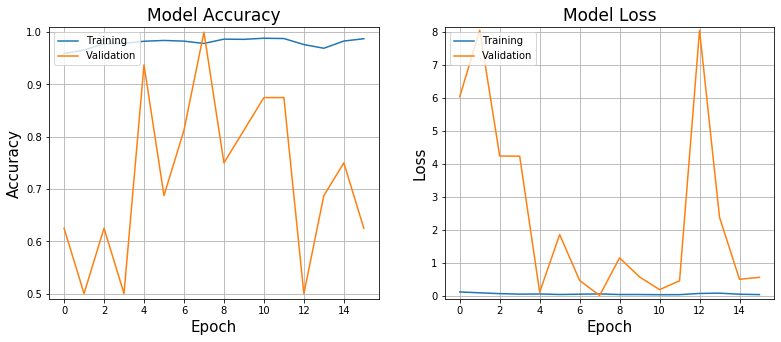

In [101]:
plot_accuracy_loss(history)

LOAD best (last saved) model

In [102]:
model = load_current_model()

List Model Directories
1 2019-10-07 19-18-26
___________________________________________________________________________
List Models in Current Directory
0 01-val_acc-0.62-val_loss-1.56.hdf5
1 06-val_acc-0.75-val_loss-0.66.hdf5
2 08-val_acc-1.00-val_loss-0.01.hdf5
3 05-val_acc-0.94-val_loss-0.11.hdf5
4 03-val_acc-0.88-val_loss-0.42.hdf5
5 10-val_acc-0.81-val_loss-0.54.hdf5
___________________________________________________________________________
Get Current Model
data/output/models/2019-10-07 19-18-26/08-val_acc-1.00-val_loss-0.01.hdf5
___________________________________________________________________________


CREATE plot parameters

In [ ]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"
batch_size_t = len(y_true_batch)
class_map = {v: k for k, v in test_generator.class_indices.items()}
dpi=100
ncols = 8
nrows = 4
count = ncols*nrows

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

COMPARE prediction with actual

Prediction results
1/1 [==============================] - 133s 133s/step
------------------------------------------------------------------------------------------
Validation Report
------------------------------------------------------------------------------------------
Precision     : 89.74%
Recall        : 98.72%
F1-Score      : 94.02%
------------------------------------------------------------------------------------------





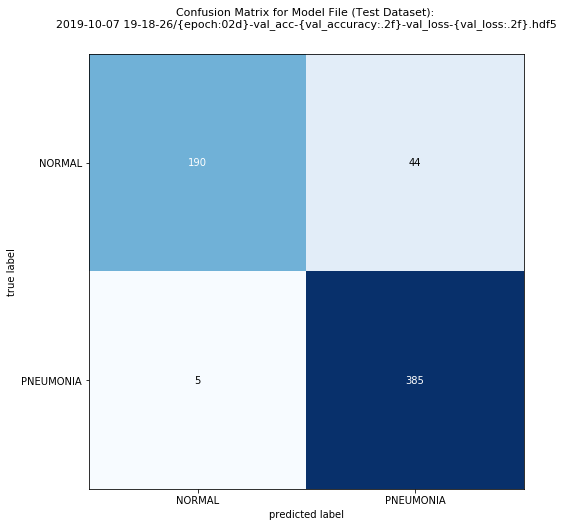




------------------------------------------------------------------------------------------
Classification Report for Model File:  2019-10-07 19-18-26/{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

   Pneumonia       0.97      0.81      0.89       234
      Normal       0.90      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.91       624
weighted avg       0.93      0.92      0.92       624

------------------------------------------------------------------------------------------


In [104]:
y_true, y_pred = prediction_results(model, test_generator, figure_directory, class_map)

SHOW prediction images

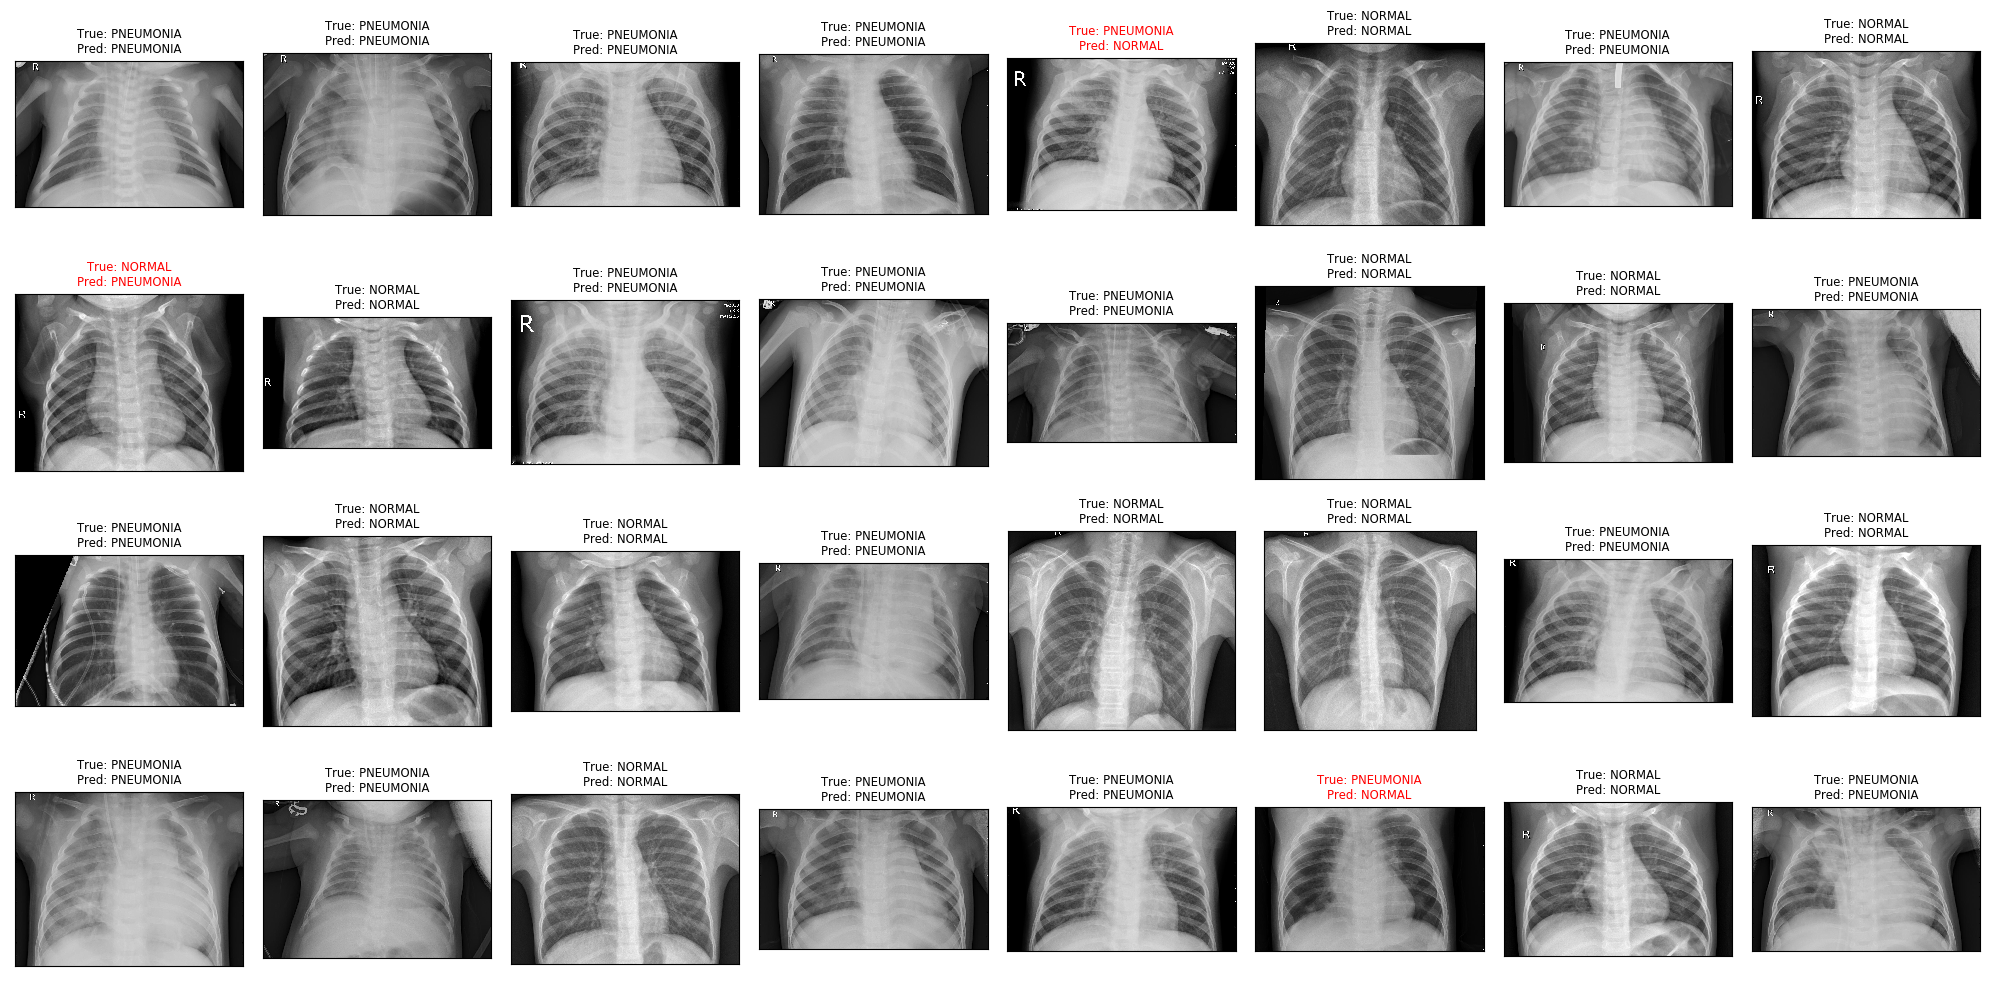

In [105]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, test_directory, image_file_name_batch, count=count, sample=True)

<hr>

### Check Image Classification Labels

HELPER Function to check classification classes, labels and predictions

In [106]:
def check_classification(num, test_generator, test_directory, class_map):
    file_names = test_generator.filenames
    actual = class_map[y_true[num]]
    predicted = class_map[y_pred[num]]
    img = cv2.imread(test_directory+'/'+ file_names[num], 1)
    plt.imshow(img)
    plt.title(test_directory+'/'+ file_names[num], fontsize=13)
    plt.xlabel(f'actual={actual}, predicted={predicted}', fontsize=13)
    plt.show()  

<hr>

#### check $"Normal"$ classification

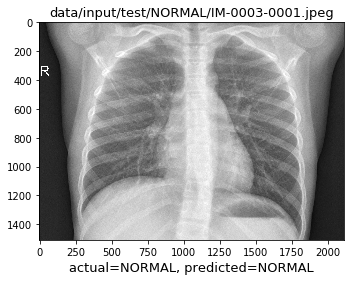

In [107]:
num=1
check_classification(num, test_generator, test_directory, class_map)

<hr>

#### check $"Pneumonia"$ classification

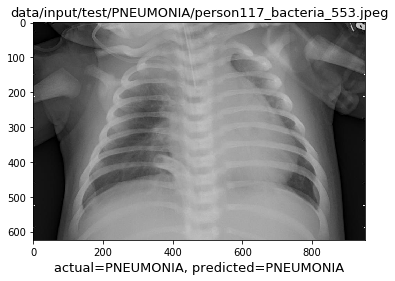

In [108]:
num=280
check_classification(num, test_generator, test_directory, class_map)

<center>End-of-Notebook</center>